In [ ]:
import numpy as np
import alc

In [2]:
X_train, Y_train, X_val, Y_val = alc.cargarDataset("cats_and_dogs/")

print(X_train.shape, Y_train.shape)  # (1536, 3000) (2, 3000)
print(X_val.shape, Y_val.shape)      # (1536, 2000) (2, 2000)

(1536, 2000) (2, 2000)
(1536, 1000) (2, 1000)


In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

if N == M:
    pXchols = alc.inversa(Xc)
    Wchols = alc.prodMat(Yc, pXchols)
else:
    if N > M:
        # print("Caso (a) N > M")
        Xh = alc.prodMat(Xc.T, Xc) 
    else:
        # print("Caso (b) N < M")
        Xh = alc.prodMat(Xc, Xc.T)
    # print("Calculo de Cholesky")
    L = alc.calculaCholesky(Xh)

    Wchols = alc.pinvEcuacionesNormales(X_train,L,Y_train)

In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

# Hace con @ para poder evaluar, en el modulo esta la version sin @
Q, R = alc.QR_con_HH_NP(Xc.T)

Whh = alc.pinvHouseHolder(Q, R, Yc)

In [ ]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

Q, R = alc.QR_con_GS(Xc.T)

Wgm = alc.pinvGramSchmidt(Q, R, Yc)

In [ ]:
# GUardar los pesos obtenidos
# np.save("wsfacu/Wchols.npy", Wchols)
# np.save("wsfacu/pXchols.npy", pXchols)
# np.save("wsfacu/Wgm.npy", Wgm)
# np.save("wsfacu/pXgm.npy", pXgm)
# np.save("wsfacu/Whh.npy", Whh)
# np.save("wsfacu/pXhh.npy", pXhh)

In [8]:
# Generar predicciones de cada uno
# Y_pred_svd = Wsvd @ X_val
Y_pred_chols = alc.prodMat(Wchols, X_val)
Y_pred_gm = alc.prodMat(Wgm, X_val)
Y_pred_hh = alc.prodMat(Whh, X_val)

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_simple(Y_pred, Y_val):
    # 1. Predicciones
    y_pred = np.argmax(Y_pred, axis=0)
    y_true = np.argmax(Y_val, axis=0)

    # 2. Matriz de confusión
    M = np.zeros((2,2), dtype=int)
    for t,p in zip(y_true, y_pred):
        M[t,p] += 1

    # 3. Accuracy
    acc = np.trace(M) / np.sum(M)

    return M, acc



Matriz de confusión:
 [[334 166]
 [150 350]]
Accuracy Cholesky: 0.684


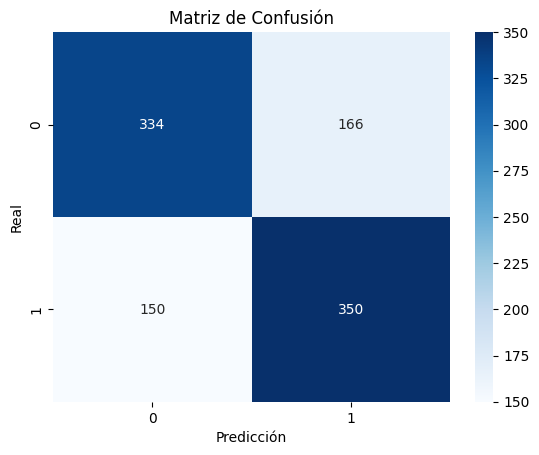

In [18]:
# Evaluar accuracy de cada método
M_chols, acc_chols = confusion_matrix_simple(Y_pred_chols, Y_val)
print("Matriz de confusión:\n", M_chols)
print("Accuracy Cholesky:", acc_chols)


sns.heatmap(M_chols, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()



Matriz de confusión:
 [[334 166]
 [150 350]]
Accuracy QR (Gram-Schmidt): 0.684


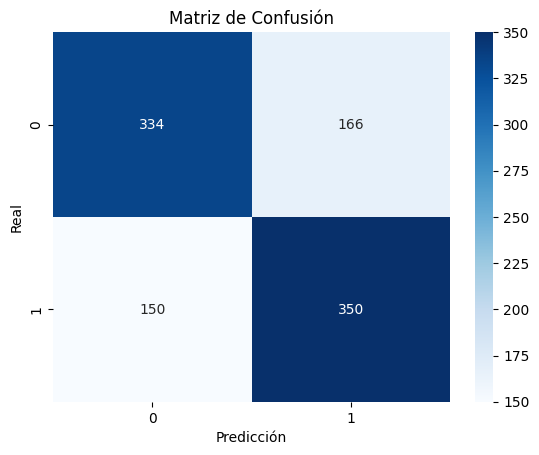

In [19]:
M_gm, acc_gm = confusion_matrix_simple(Y_pred_gm, Y_val)
print("Matriz de confusión:\n", M_gm)
print("Accuracy QR (Gram-Schmidt):", acc_gm)

sns.heatmap(M_gm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()



Matriz de confusión:
 [[334 166]
 [150 350]]
Accuracy QR (Householder): 0.684


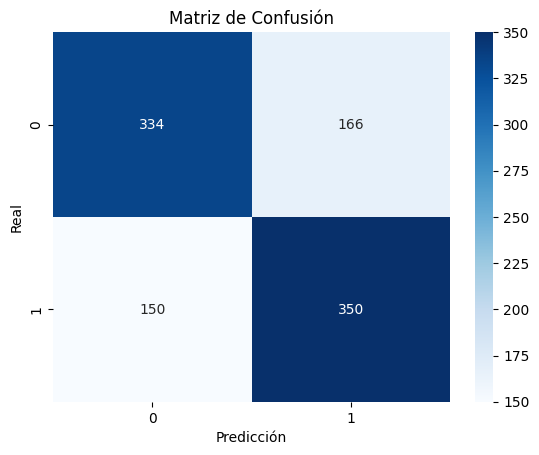

In [20]:
M_hh, acc_hh = confusion_matrix_simple(Y_pred_hh, Y_val)
print("Matriz de confusión:\n", M_hh)
print("Accuracy QR (Householder):", acc_hh)

sns.heatmap(M_hh, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
Wsvd, pXsvd = anto2.fullyConnectedSVD(X_train, Y_train)

In [8]:
print("Calcula bien pseudoinversa con SVD: ", alc.esPseudoInversa(X_train, pXsvd, tol=3))

Calcula bien pseudoinversa con SVD:  False


In [13]:
np.save("wsfacu/Wsvd.npy", Wsvd)
np.save("wsfacu/pXsvd.npy", pXsvd)

Matriz de confusión:
 [[333 167]
 [149 351]]
Accuracy SVD: 0.684


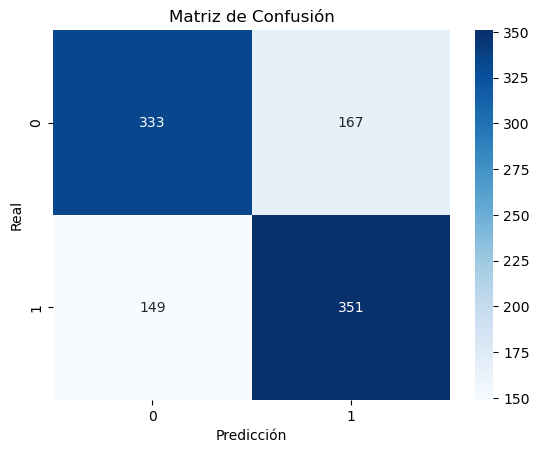

In [11]:
# Predicciones del algoritmo con SVD
Y_pred_svd = Wsvd @ X_val

# Accuracy y matriz de confusión
M_svd, acc_svd = confusion_matrix_simple(Y_pred_svd, Y_val)
print("Matriz de confusión:\n", M_svd)
print("Accuracy SVD:", acc_svd)

sns.heatmap(M_svd, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()